In [1]:
import re
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
import plotly.express as px

In [2]:
Clean_DF = pd.read_csv('Steam_Clean_Data.csv')
Train_reco = pd.read_csv('Train_reco.csv')
Test_reco = pd.read_csv('Test_reco.csv')
Train_auth = pd.read_csv('Train_auth.csv')
Test_auth = pd.read_csv('Test_auth.csv')

In [3]:
Tfidf_reco=TfidfVectorizer(
    input="content",
    lowercase=True, 
    stop_words = "english",max_features = 1000)
Train_DTM_reco = Tfidf_reco.fit_transform(Train_reco['review'])

In [4]:
Train_DTM_DF_reco=pd.DataFrame(Train_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())

In [5]:
## Instantiate
nb_reco=GaussianNB()
nb_reco.fit(Train_DTM_DF_reco, Train_reco['recommendation'])

GaussianNB()

In [26]:
'''fig = plt.figure(figsize=(30, 30))
MyTree1 = tree.plot_tree(MyDT1, impurity=True, rounded=True,
                         feature_names = feature_names, 
                         class_names = class_names, 
                         filled=True, fontsize=13)'''

'fig = plt.figure(figsize=(30, 30))\nMyTree1 = tree.plot_tree(MyDT1, impurity=True, rounded=True,\n                         feature_names = feature_names, \n                         class_names = class_names, \n                         filled=True, fontsize=13)'

In [6]:
Test_DTM_reco = Tfidf_reco.transform(Test_reco['review'])
Test_DTM_DF_reco=pd.DataFrame(Test_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())
DT_pred_reco=nb_reco.predict(Test_DTM_DF_reco)


The confusion matrix is:
[[21507  6114]
 [13001 43194]]


0.7719409182017754

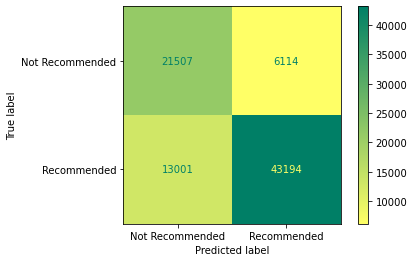

In [7]:
bn_matrix = confusion_matrix(Test_reco['recommendation'], DT_pred_reco)
print("\nThe confusion matrix is:")
print(bn_matrix)
plot_confusion_matrix(nb_reco, Test_DTM_DF_reco, Test_reco['recommendation'], cmap = 'summer_r')
#plt.savefig('MyTree1_cm.png')
accuracy_score(Test_reco['recommendation'], DT_pred_reco)

In [8]:
Tfidf_auth=TfidfVectorizer(
    input="content",
    lowercase=True, 
    stop_words = "english",max_features = 1000)
Train_DTM_auth = Tfidf_auth.fit_transform(Train_auth['review'])
Train_DTM_DF_auth=pd.DataFrame(Train_DTM_auth.toarray(),columns=Tfidf_auth.get_feature_names())

In [9]:
## Instantiate
nb_auth=GaussianNB()
nb_auth.fit(Train_DTM_DF_auth, Train_auth['authentic'])

GaussianNB()

In [11]:
Test_DTM_auth = Tfidf_auth.transform(Test_auth['review'])
Test_DTM_DF_auth=pd.DataFrame(Test_DTM_auth.toarray(),columns=Tfidf_auth.get_feature_names())
DT_pred_auth=nb_auth.predict(Test_DTM_DF_auth)


The confusion matrix is:
[[28034 25185]
 [11588 19009]]


0.5612651522382361

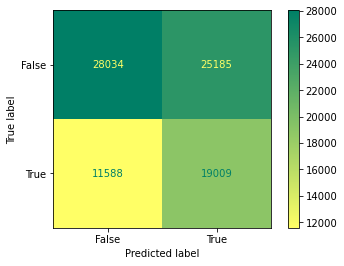

In [13]:
bn_matrix = confusion_matrix(Test_auth['authentic'], DT_pred_auth)
print("\nThe confusion matrix is:")
print(bn_matrix)
plot_confusion_matrix(nb_auth, Test_DTM_DF_auth, Test_auth['authentic'], cmap = 'summer_r')
#plt.savefig('MyTree1_cm.png')
accuracy_score(Test_auth['authentic'], DT_pred_auth)